In [1]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt


np.random.seed(5997)
tf.random.set_seed(5995)

In [2]:
tf.config.list_physical_devices('GPU')

[]

11501568/11490434 [==============================] - 0s 0us/step


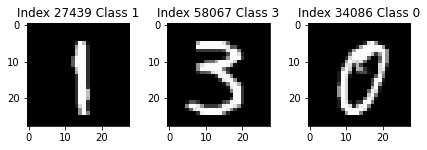

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST or FMNIST
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)


# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

# Important
* Always have a validation set, the procedure to create validation or dev set is by performing random sample without replacement on train set and then only using that fraction as dev set. 
* Simple approach is to set some K samples, you can extract them from start, mid or end.
* Imagine validation set that partially approximates test set distribution and we assume our model would produce identical results when we test it on test set.
* Always optimize your hyperparameters by looking at performance on validation set and not test set.
* Do not touch test set, we have this to test how our model would work on unseen data.

In [4]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

# Split dataset into batches
#train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
#test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [5]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [6]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


# C1 Normal + SGD

In [ ]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [ ]:
# import tensorflow as tf
# from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
# class CustomOptimizer(OptimizerV2):

#     def __init__(self,
#                  learning_rate=0.001,
#                  beta_1=0.9,
#                  beta_2=0.999,
#                  beta_3=0.999987,
#                  epsilon=1e-8,
#                  weight_decay=0.0,
#                  name='CustomOptimizer', **kwargs):
#         super(CustomOptimizer, self).__init__(name, **kwargs)

#         self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
#         self._set_hyper('beta_1', beta_1)
#         self._set_hyper('beta_2', beta_2)
#         self._set_hyper('beta_3', beta_3)
#         self._set_hyper('decay', self._initial_decay)
#         self.epsilon = epsilon
#         self.weight_decay = weight_decay


#     def _resource_apply_dense(self, grad, var, gvs):
#         for va in var:
#             self.add_slot(va, 'm')
#         for va in var:
#             self.add_slot(va, 'v')
#         for va in var:
#             self.add_slot(va, 'u')
#         var_dtype = var[0].dtype.base_dtype

#         beta_1_t = self._get_hyper('beta_1', var_dtype)
#         beta_2_t = self._get_hyper('beta_2', var_dtype)
#         beta_3_t = self._get_hyper('beta_3', var_dtype)

#         learning_rate = self._get_hyper('learning_rate', var_dtype)

#         epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

#         t = tf.cast(self.iterations + 1, var_dtype)

#         update_ops = []

#         for (g,var) in gvs:

#           m = self.get_slot(var, 'm')
#           v = self.get_slot(var, 'v')
#           u = self.get_slot(var, 'u')

#           m_t = (beta_1_t * m) + (1. - beta_1_t) * g
#           v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
#           u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g

#           beta1_t = beta_1_t ** t
#           beta2_t = beta_2_t ** t
#           beta3_t = beta_3_t ** t
          
#           m_t_hat = m_t/(1-beta1_t)
#           v_t_hat = v_t/(1-beta2_t)
#           u_t_hat = u_t/(1-beta3_t)

#           m_t = tf.compat.v1.assign(m, m_t)
#           v_t = tf.compat.v1.assign(v, v_t)
#           u_t = tf.compat.v1.assign(u, u_t)

#           update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
#           update_ops.append(var.assign_add(update))

#         return tf.group(*update_ops)


Train Accuracy: 0.9155
Number of Epoch = 1 - Average Cross Entropy:= 0.0037812588500976563 

Validation Accuracy: 0.9214

Train Accuracy: 0.9365
Number of Epoch = 2 - Average Cross Entropy:= 0.0016907225036621094 

Validation Accuracy: 0.9419

Train Accuracy: 0.9536
Number of Epoch = 3 - Average Cross Entropy:= 0.0012759355163574218 

Validation Accuracy: 0.9535

Train Accuracy: 0.9600
Number of Epoch = 4 - Average Cross Entropy:= 0.001022857437133789 

Validation Accuracy: 0.9595

Train Accuracy: 0.9659
Number of Epoch = 5 - Average Cross Entropy:= 0.0008465966796875 

Validation Accuracy: 0.9626

Train Accuracy: 0.9708
Number of Epoch = 6 - Average Cross Entropy:= 0.0007152566528320312 

Validation Accuracy: 0.9650

Train Accuracy: 0.9700
Number of Epoch = 7 - Average Cross Entropy:= 0.0006099381637573242 

Validation Accuracy: 0.9628

Train Accuracy: 0.9756
Number of Epoch = 8 - Average Cross Entropy:= 0.0005239120864868164 

Validation Accuracy: 0.9660

Train Accuracy: 0.9820
Numb

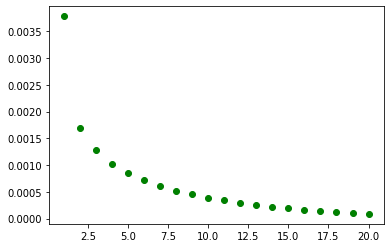

In [ ]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


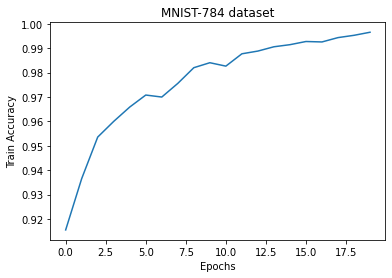

In [ ]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0243

Test Accuracy: 0.97


# C1 Normal + SGD + L2

In [ ]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    # backward pass
    # """
    # # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    # with tf.GradientTape() as tape:
    #   predicted = self.forward(X_train)
    #   # print('OK')
    #   current_loss = self.loss(predicted, y_train)
    #   # print('OK')
    # grads = tape.gradient(current_loss, self.variables)
    # # print('OK')
    # return grads, self.variables
    # # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))
 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))


    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      #L1 = (tf.reduce_sum(tf.math.abs(self.W1))+ tf.reduce_sum(tf.math.abs(self.W2))+tf.reduce_sum(tf.math.abs(self.W3)) + tf.reduce_sum(tf.math.abs(self.W4))) # got 94% with just L1.
      L2= (tf.reduce_sum(tf.square(self.W1))+ tf.reduce_sum(tf.square(self.W2))+tf.reduce_sum(tf.square(self.W3)) + tf.reduce_sum(tf.square(self.W4)))/4 # got 97% with just L2.
      current_loss = self.loss(predicted, y_train) + 0.001 * L2 #+ 0.005 * L2 #L1 and L2 togeh
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.9051
Number of Epoch = 1 - Average Cross Entropy:= 0.003928327941894532 

Validation Accuracy: 0.9148

Train Accuracy: 0.9402
Number of Epoch = 2 - Average Cross Entropy:= 0.0016860038757324218 

Validation Accuracy: 0.9452

Train Accuracy: 0.9574
Number of Epoch = 3 - Average Cross Entropy:= 0.001267034683227539 

Validation Accuracy: 0.9590

Train Accuracy: 0.9653
Number of Epoch = 4 - Average Cross Entropy:= 0.0010301101684570312 

Validation Accuracy: 0.9628

Train Accuracy: 0.9709
Number of Epoch = 5 - Average Cross Entropy:= 0.000859361801147461 

Validation Accuracy: 0.9653

Train Accuracy: 0.9755
Number of Epoch = 6 - Average Cross Entropy:= 0.0007406903839111328 

Validation Accuracy: 0.9690

Train Accuracy: 0.9775
Number of Epoch = 7 - Average Cross Entropy:= 0.0006469833374023438 

Validation Accuracy: 0.9711

Train Accuracy: 0.9773
Number of Epoch = 8 - Average Cross Entropy:= 0.0005715763854980469 

Validation Accuracy: 0.9685

Train Accuracy: 0.9795
Num

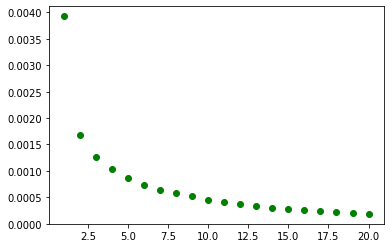

In [ ]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


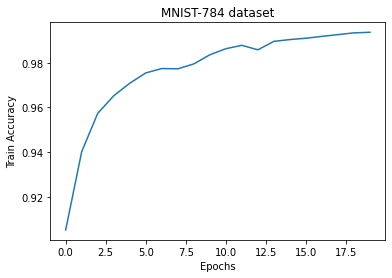

In [ ]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0217

Test Accuracy: 0.97


# C1 Normal + Adam

In [ ]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.8725
Number of Epoch = 1 - Average Cross Entropy:= 0.0084701953125 

Validation Accuracy: 0.8854

Train Accuracy: 0.9067
Number of Epoch = 2 - Average Cross Entropy:= 0.0029119656372070314 

Validation Accuracy: 0.9177

Train Accuracy: 0.9220
Number of Epoch = 3 - Average Cross Entropy:= 0.002279121551513672 

Validation Accuracy: 0.9301

Train Accuracy: 0.9319
Number of Epoch = 4 - Average Cross Entropy:= 0.0019649270629882813 

Validation Accuracy: 0.9382

Train Accuracy: 0.9386
Number of Epoch = 5 - Average Cross Entropy:= 0.001758016815185547 

Validation Accuracy: 0.9438

Train Accuracy: 0.9437
Number of Epoch = 6 - Average Cross Entropy:= 0.0016061219787597656 

Validation Accuracy: 0.9469

Train Accuracy: 0.9479
Number of Epoch = 7 - Average Cross Entropy:= 0.0014867137145996093 

Validation Accuracy: 0.9513

Train Accuracy: 0.9509
Number of Epoch = 8 - Average Cross Entropy:= 0.0013965449523925782 

Validation Accuracy: 0.9533

Train Accuracy: 0.9535
Number o

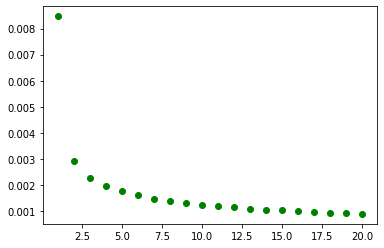

In [ ]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


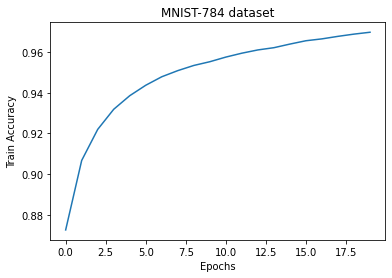

In [ ]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [ ]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0344

Test Accuracy: 0.96


# C1 Normal + Rmsprop

In [8]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x


 def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4)
    
    with tf.GradientTape() as tape:
        
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
        
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))

    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)



Train Accuracy: 0.9121
Number of Epoch = 1 - Average Cross Entropy:= 0.004602061767578125 

Validation Accuracy: 0.9235

Train Accuracy: 0.9348
Number of Epoch = 2 - Average Cross Entropy:= 0.0018807003784179687 

Validation Accuracy: 0.9419

Train Accuracy: 0.9479
Number of Epoch = 3 - Average Cross Entropy:= 0.0015069522094726562 

Validation Accuracy: 0.9516

Train Accuracy: 0.9552
Number of Epoch = 4 - Average Cross Entropy:= 0.001294707489013672 

Validation Accuracy: 0.9551

Train Accuracy: 0.9623
Number of Epoch = 5 - Average Cross Entropy:= 0.0011615845489501952 

Validation Accuracy: 0.9610

Train Accuracy: 0.9646
Number of Epoch = 6 - Average Cross Entropy:= 0.0010706739044189454 

Validation Accuracy: 0.9626

Train Accuracy: 0.9678
Number of Epoch = 7 - Average Cross Entropy:= 0.0010106636810302734 

Validation Accuracy: 0.9657

Train Accuracy: 0.9702
Number of Epoch = 8 - Average Cross Entropy:= 0.0009639342498779297 

Validation Accuracy: 0.9651

Train Accuracy: 0.9706
Nu

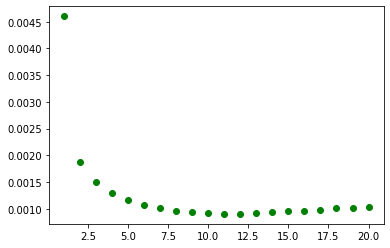

In [11]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


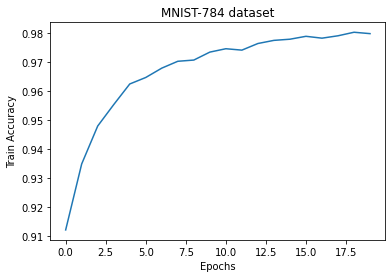

In [12]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [13]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0528

Test Accuracy: 0.97


# C1 Normal + Custom optimizer (1e-2)



In [22]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [23]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=1e-2,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.9556
Number of Epoch = 1 - Average Cross Entropy:= 0.00249611083984375 

Validation Accuracy: 0.9566

Train Accuracy: 0.9685
Number of Epoch = 2 - Average Cross Entropy:= 0.001112378921508789 

Validation Accuracy: 0.9632

Train Accuracy: 0.9749
Number of Epoch = 3 - Average Cross Entropy:= 0.00082909423828125 

Validation Accuracy: 0.9671

Train Accuracy: 0.9791
Number of Epoch = 4 - Average Cross Entropy:= 0.0006587041473388672 

Validation Accuracy: 0.9691

Train Accuracy: 0.9823
Number of Epoch = 5 - Average Cross Entropy:= 0.000540702781677246 

Validation Accuracy: 0.9695

Train Accuracy: 0.9849
Number of Epoch = 6 - Average Cross Entropy:= 0.00045006591796875 

Validation Accuracy: 0.9709

Train Accuracy: 0.9869
Number of Epoch = 7 - Average Cross Entropy:= 0.00037495628356933595 

Validation Accuracy: 0.9715

Train Accuracy: 0.9890
Number of Epoch = 8 - Average Cross Entropy:= 0.0003125432395935059 

Validation Accuracy: 0.9725

Train Accuracy: 0.9908
Number 

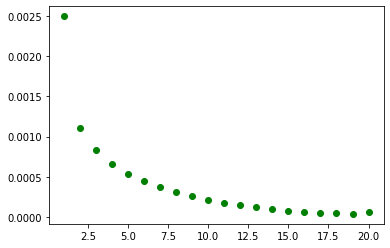

In [24]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=0.01,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-2,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


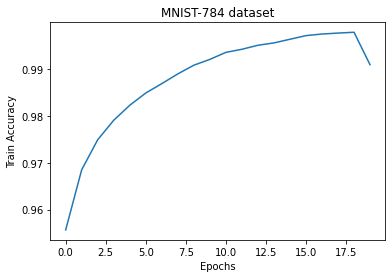

In [25]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [26]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0354

Test Accuracy: 0.97


# C1 Normal + Custom optimizer (1e-3)



In [17]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [18]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=1e-3,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.9530
Number of Epoch = 1 - Average Cross Entropy:= 0.0025629315185546875 

Validation Accuracy: 0.9577

Train Accuracy: 0.9673
Number of Epoch = 2 - Average Cross Entropy:= 0.0011280509185791015 

Validation Accuracy: 0.9653

Train Accuracy: 0.9737
Number of Epoch = 3 - Average Cross Entropy:= 0.0008350435638427734 

Validation Accuracy: 0.9670

Train Accuracy: 0.9779
Number of Epoch = 4 - Average Cross Entropy:= 0.0006603125762939453 

Validation Accuracy: 0.9685

Train Accuracy: 0.9815
Number of Epoch = 5 - Average Cross Entropy:= 0.0005404006195068359 

Validation Accuracy: 0.9698

Train Accuracy: 0.9844
Number of Epoch = 6 - Average Cross Entropy:= 0.00044830322265625 

Validation Accuracy: 0.9714

Train Accuracy: 0.9863
Number of Epoch = 7 - Average Cross Entropy:= 0.0003730385208129883 

Validation Accuracy: 0.9728

Train Accuracy: 0.9884
Number of Epoch = 8 - Average Cross Entropy:= 0.00031407077789306643 

Validation Accuracy: 0.9726

Train Accuracy: 0.9897
N

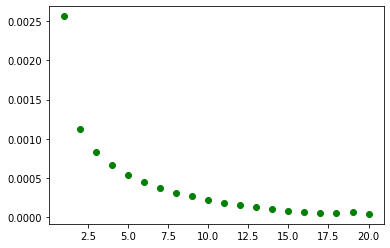

In [19]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-2,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


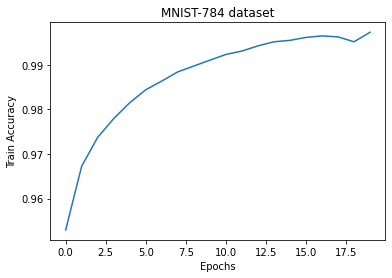

In [20]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [21]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0310

Test Accuracy: 0.97


# C1 Normal + Custom optimizer (1e-4)



In [27]:
# Define class to build mlp model
class MLP(object):
 def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden1: int, size of the 1st hidden layer
    size_hidden2: int, size of the 2nd hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
  
 def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y

 def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    #y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_true_tf = tf.cast(y_true, dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    loss_x = cce(y_true_tf, y_pred_tf)
    # Use keras or tf_softmax, both should work for any given model
    #loss_x = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred_tf, labels=y_true_tf))
    
    return loss_x

 def backward(self, X_train, y_train):
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
    
    # with tf.GradientTape() as tape:
        
    #   predicted = self.forward(X_train)
    #   current_loss = self.loss(predicted, y_train)
        
    # grads = tape.gradient(current_loss, self.variables)
    # optimizer.apply_gradients(zip(grads, self.variables))
    """
    backward pass
    """
    # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      # print('OK')
      current_loss = self.loss(predicted, y_train)
      # print('OK')
    grads = tape.gradient(current_loss, self.variables)
    # print('OK')
    return grads, self.variables
    # print(grads)

    # AdamOptimizer.apply_gradients(zip(grads, self.variables))



    
           
 def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #X_tf = X
    
    # Compute values in hidden layers
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    
    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this 
    # Second add tf.Softmax(output) and then return this variable
    return (output)


In [28]:
import tensorflow as tf
from tensorflow.python.keras.optimizer_v2.optimizer_v2 import OptimizerV2
class RectifiedAdam(OptimizerV2):

    def __init__(self,
                 learning_rate=0.0001,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 name='RectifiedAdam', **kwargs):
        super(RectifiedAdam, self).__init__(name, **kwargs)

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('beta_3', beta_3)
        self._set_hyper('decay', self._initial_decay)
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    # def _create_slots(self, var_list):
    #     for var in var_list:
    #         self.add_slot(var, 'm')
    #     for var in var_list:
    #         self.add_slot(var, 'v')

    def _resource_apply_dense(self, grad, var, gvs):
        for va in var:
            self.add_slot(va, 'm')
        for va in var:
            self.add_slot(va, 'v')
        for va in var:
            self.add_slot(va, 'u')
        var_dtype = var[0].dtype.base_dtype
        # lr_t = self._decayed_lr(var_dtype)
        # m = self.get_slot(var, 'm')
        # v = self.get_slot(var, 'v')
        beta_1_t = self._get_hyper('beta_1', var_dtype)
        beta_2_t = self._get_hyper('beta_2', var_dtype)
        beta_3_t = self._get_hyper('beta_3', var_dtype)
        learning_rate = self._get_hyper('learning_rate', var_dtype)

        epsilon_t = tf.convert_to_tensor(self.epsilon, var_dtype)

        t = tf.cast(self.iterations + 1, var_dtype)
        update_ops = []

        for (g,var) in gvs:

          m = self.get_slot(var, 'm')
          v = self.get_slot(var, 'v')
          u = self.get_slot(var, 'u')

          m_t = (beta_1_t * m) + (1. - beta_1_t) * g
          # print('###################')
          # print(g)
          v_t = (beta_2_t * v) + (1. - beta_2_t) * tf.square(g)
          u_t = (beta_3_t * u) + (1. - beta_3_t)* g* g* g
          # print(u_t)
          beta1_t = beta_1_t ** t
          beta2_t = beta_2_t ** t
          beta3_t = beta_3_t ** t
          
          m_t_hat = m_t/(1-beta1_t)
          v_t_hat = v_t/(1-beta2_t)
          u_t_hat = u_t/(1-beta3_t)

          m_t = tf.compat.v1.assign(m, m_t)
          v_t = tf.compat.v1.assign(v, v_t)
          u_t = tf.compat.v1.assign(u, u_t)
          # print(m_t)
          # print(u_t)
          # dom2 = self.epsilon
          # dom3 = np.cbrt(u_t_hat)*self.epsilon + 1e-5


          update = -learning_rate*m_t_hat/(tf.sqrt(v_t_hat) + np.cbrt(u_t_hat)*self.epsilon + 1e-5)
          
          update_ops.append(var.assign_add(update))

        return tf.group(*update_ops)


Train Accuracy: 0.8700
Number of Epoch = 1 - Average Cross Entropy:= 0.0070186669921875 

Validation Accuracy: 0.8861

Train Accuracy: 0.8984
Number of Epoch = 2 - Average Cross Entropy:= 0.003189068908691406 

Validation Accuracy: 0.9069

Train Accuracy: 0.9102
Number of Epoch = 3 - Average Cross Entropy:= 0.0026405364990234373 

Validation Accuracy: 0.9180

Train Accuracy: 0.9177
Number of Epoch = 4 - Average Cross Entropy:= 0.002359075469970703 

Validation Accuracy: 0.9239

Train Accuracy: 0.9236
Number of Epoch = 5 - Average Cross Entropy:= 0.0021677432250976564 

Validation Accuracy: 0.9280

Train Accuracy: 0.9282
Number of Epoch = 6 - Average Cross Entropy:= 0.0020220732116699217 

Validation Accuracy: 0.9320

Train Accuracy: 0.9318
Number of Epoch = 7 - Average Cross Entropy:= 0.001903874969482422 

Validation Accuracy: 0.9360

Train Accuracy: 0.9353
Number of Epoch = 8 - Average Cross Entropy:= 0.0018031541442871093 

Validation Accuracy: 0.9391

Train Accuracy: 0.9389
Number

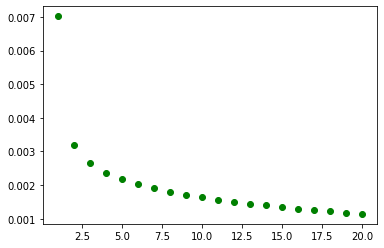

In [30]:
# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')
ao = RectifiedAdam(learning_rate=1e-4,
                 beta_1=0.9,
                 beta_2=0.999,
                 beta_3=0.999987,
                 epsilon=1e-4,
                 weight_decay=0.0,
                 name='RectifiedAdam')
time_start = time.time()
acc = []
for epoch in range(NUM_EPOCHS):
    
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
    
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(5997)).batch(128)
  kz = 0
  accuracy_z = 0.0
  cur_train_acc = 0.0
  for inputs, outputs in train_ds:
    qw, tr = tf.shape(inputs)
    kz = kz + 1
    preds = mlp_on_cpu.forward(inputs) 
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)

    g,v = mlp_on_cpu.backward(inputs, outputs)
    gvs=zip(g, v)
    # print(g[0],v[1])
    ao._resource_apply_dense(g,v,gvs)

  preds = mlp_on_cpu.forward(X_train)
  # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
  preds = tf.nn.softmax(preds)
  correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
  accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_train_acc += accuracy_z.numpy()
  ds = cur_train_acc
  print('\nTrain Accuracy: {:.4f}'.format(ds))
  acc.append(ds)
  print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
  preds_val = mlp_on_cpu.forward(X_val)
  preds_val = tf.nn.softmax(preds_val)
  correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

  # Calculate accuracy
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
  cur_val_acc = accuracy.numpy()

  print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
  
  plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

        
time_taken = time.time() - time_start
    
# Validate model
    


print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs


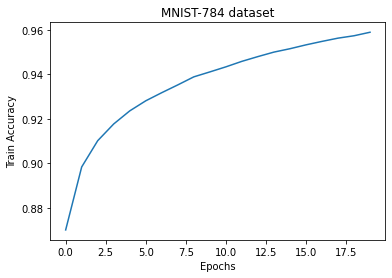

In [31]:
from matplotlib import pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Train Accuracy')
plt.title('MNIST-784 dataset')
plt.plot(acc)

In [32]:
# Initialize
test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_prediction = tf.Variable(0, dtype=tf.float32)


test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)


#test_loss_total = 0.0
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
print('Test loss: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))

# Test model
preds_test = mlp_on_cpu.forward(X_test)
preds_test = tf.nn.softmax(preds_test)
correct_prediction = tf.equal(tf.argmax(preds_test, 1), tf.argmax(y_test, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
cur_test_acc = accuracy.numpy()
print('\nTest Accuracy: {:.2f}'.format(cur_test_acc))

Test loss: 0.0386

Test Accuracy: 0.95
